In [1]:
import numpy as np
import pandas as pd
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="5.0percent"
diffusion="0.1percent"
# file_id = "1"
# file_id = "2954"
file_id = "2638"


hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_5.0percent_smear_{file_id}.h5", "MC/hits")


display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,event_id,x,y,z,energy
0,395850,-865.768311,2451.984131,4381.113281,0.000025
1,395850,-780.871155,2438.028076,4383.000000,0.000025
2,395850,-844.398499,2403.236084,4403.018555,0.000025
3,395850,-748.367859,2616.320557,4405.392578,0.000025
4,395850,-866.846741,2453.144043,4406.033203,0.000025
...,...,...,...,...,...
251332,395909,-1792.564941,2645.648193,5135.429199,0.000025
251333,395909,-1636.236084,2596.359375,5136.860352,0.000050
251334,395909,-1800.428467,2671.194336,5140.295898,0.000025
251335,395909,-1736.265259,2706.596191,5141.206543,0.000025


[395850 395851 395852 395853 395854 395855 395856 395857 395858 395859
 395860 395861 395862 395863 395864 395865 395866 395867 395868 395869
 395870 395871 395872 395873 395874 395875 395876 395877 395878 395879
 395880 395881 395882 395883 395884 395885 395886 395887 395888 395889
 395890 395891 395892 395893 395894 395895 395896 395897 395898 395899
 395900 395901 395902 395903 395904 395905 395906 395907 395908 395909]


In [2]:
eid=320000
eid=event_list[0]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
0,395850,-872.465698,2421.406494,4451.626465,0.000025
1,395850,-872.745789,2420.819824,4452.049805,0.000074
2,395850,-871.317993,2423.465576,4452.322266,0.000893
3,395850,-870.322388,2425.128906,4453.188477,0.001116
4,395850,-867.811768,2428.922852,4455.103027,0.000298
...,...,...,...,...,...
1015,395850,-837.277283,2767.225342,5256.319336,0.005704
1016,395850,-827.997314,2777.996582,5256.583008,0.001116
1017,395850,-835.717529,2769.689209,5256.650391,0.002455
1018,395850,-831.439758,2774.517578,5256.776367,0.001686


In [3]:

Diff_smear = 0.0
energy_threshold=0
diff_scale_factor=7 # this scales the radius size

# The percentage 0 is actually a small amount
if (diffusion == "0.05percent"):
    Diff_smear = 0.05 # mm / sqrt(cm)
elif (diffusion == "0.1percent"):
    Diff_smear = 0.95 # mm / sqrt(cm)
    energy_threshold=0.0004
    diff_scale_factor=5
elif (diffusion == "0.25percent"):
    Diff_smear = 0.703 # mm / sqrt(cm)
    energy_threshold=0.0004
    diff_scale_factor=5
elif (diffusion == "0.5percent"):
    Diff_smear = 0.507 # mm / sqrt(cm)
    energy_threshold=0.0004
    diff_scale_factor=5
elif (diffusion == "5.0percent"):

    if (pressure == 1):
        Diff_smear = 0.290 # mm / sqrt(cm)
        diff_scale_factor=7
    elif (pressure == 5):
        Diff_smear = 0.270
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 10):
        Diff_smear = 0.251
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 15):
        Diff_smear = 0.258
        diff_scale_factor=5
        energy_threshold=0.001
    else:
        print("Error pressure not found")
else:
    print("Error CO2 percentage not defined at 75 V/cm field")

if (Diff_smear == 0.0):
    print("Error diffusion value not configured properly")

print("energy_threshold:", energy_threshold)


mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

energy_threshold: 0.0004


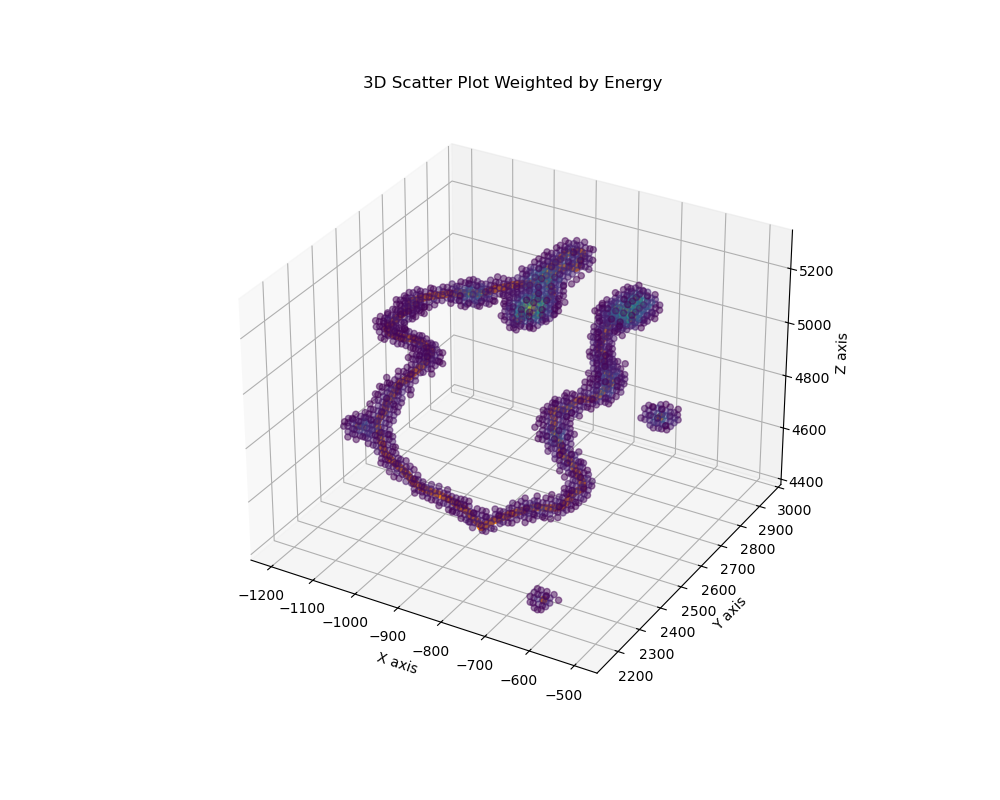

In [4]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


data = CutandRedistibuteEnergy(data, energy_threshold)

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [5]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

,event_id,x,y,z,energy
0,395850,-1198.296265,2438.880859,4680.301270,0.000813
1,395850,-1197.793579,2419.190674,4681.529785,0.000753
2,395850,-1196.901367,2438.438477,4697.311523,0.000904
3,395850,-1196.798340,2457.457275,4680.592773,0.000512
4,395850,-1196.168945,2420.530029,4698.159180,0.000512
...,...,...,...,...,...
1680,395850,-501.993164,2575.175537,4939.430664,0.000663
1681,395850,-501.920258,2540.448486,4940.475586,0.001626
1682,395850,-501.761932,2541.342285,4921.943359,0.001265
1683,395850,-500.972382,2559.472168,4939.905273,0.001747


1685


,event_id,x,y,z,energy
0,395850,-1198.296265,2438.880859,4680.301270,0.000813
1,395850,-1197.793579,2419.190674,4681.529785,0.000753
2,395850,-1196.901367,2438.438477,4697.311523,0.000904
3,395850,-1196.798340,2457.457275,4680.592773,0.000512
4,395850,-1196.168945,2420.530029,4698.159180,0.000512
...,...,...,...,...,...
1680,395850,-501.993164,2575.175537,4939.430664,0.000663
1681,395850,-501.920258,2540.448486,4940.475586,0.001626
1682,395850,-501.761932,2541.342285,4921.943359,0.001265
1683,395850,-500.972382,2559.472168,4939.905273,0.001747


Mean z: 4886.032  diffusion =  105
Mean Sigma:  105
28 2.459589545847848


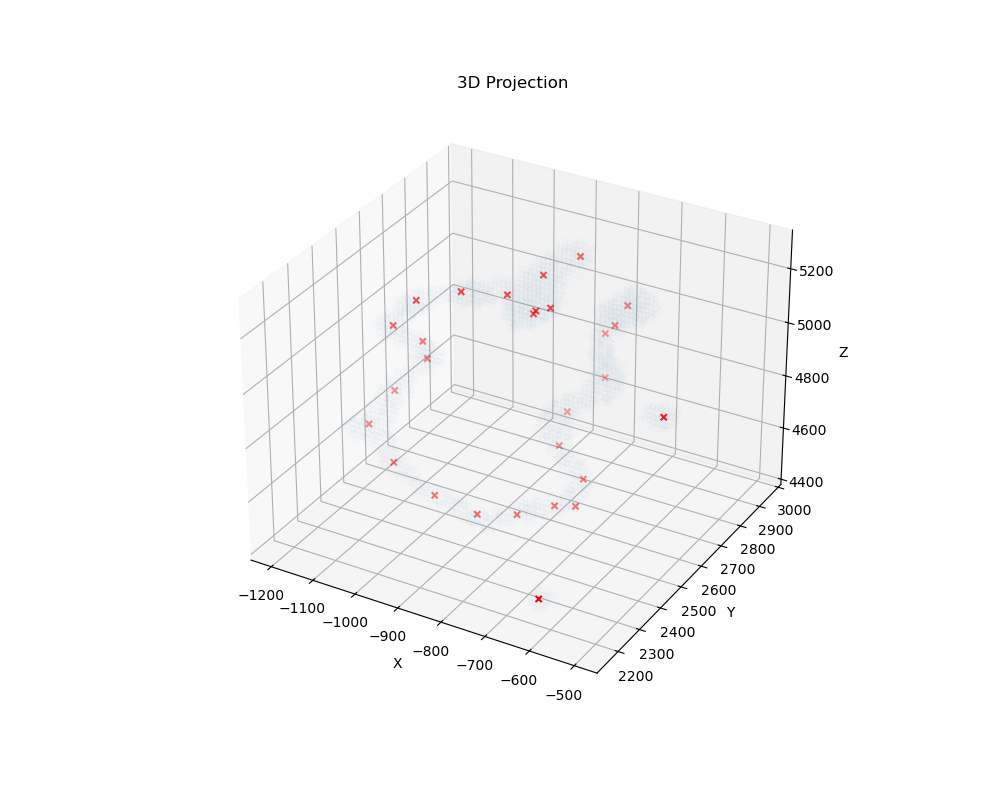

In [6]:

# def GetMinima(index, all_visited_, input_data, temp_dist_matrix, R):


#     distances_from_index = temp_dist_matrix[index] # distances for node to others
#     sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

#     closest_nodes = sorted_indices[distances_from_index[sorted_indices] < R]
    
#     closest_nodes = list(set(closest_nodes) - set(all_visited_))

#     selected_rows = input_data.iloc[closest_nodes] # Df containing the nodes within distance

#     # Compute the mean of x, y, and z columns
#     mean_x = selected_rows['x'].median()
#     mean_y = selected_rows['y'].median()
#     mean_z = selected_rows['z'].median()
#     energy_sum = selected_rows['energy'].sum()
#     mean_point = np.array([mean_x, mean_y, mean_z, energy_sum])

#     all_visited = all_visited_ + list(closest_nodes)

#     return mean_point, all_visited


# def Cluster(input_data, R):

#     node_centers = []
#     all_visited = []
#     indexes = input_data.index.values
#     indexes_set = set(indexes)

#     temp_dist_matrix = distance_matrix(input_data[['x', 'y', 'z']], input_data[['x', 'y', 'z']])

#     for i in range(len(input_data)):

#         all_visited_set = set(all_visited)

#         # Convert arrays to sets and perform the difference
#         filtered_indexes = list(indexes_set - all_visited_set)

#         if not filtered_indexes:
#             break

#         # random_index = np.random.choice(filtered_indexes)
#         random_index = filtered_indexes[0]
#         median, all_visited = GetMinima(random_index, all_visited, input_data, temp_dist_matrix, R)

#         node_centers.append(median)

#     return pd.DataFrame(node_centers, columns=['x', 'y', 'z', 'energy'])



display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)

# mean_sigma = round(6*0.29*np.sqrt(0.1*data.z.mean()))
# mean_sigma = round(6*0.9*np.sqrt(0.1*data.z.mean()))
print("Mean Sigma: ", mean_sigma)

node_centers_df = Cluster(data, mean_sigma)


# display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(node_centers_df['x'], node_centers_df['y'], node_centers_df['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



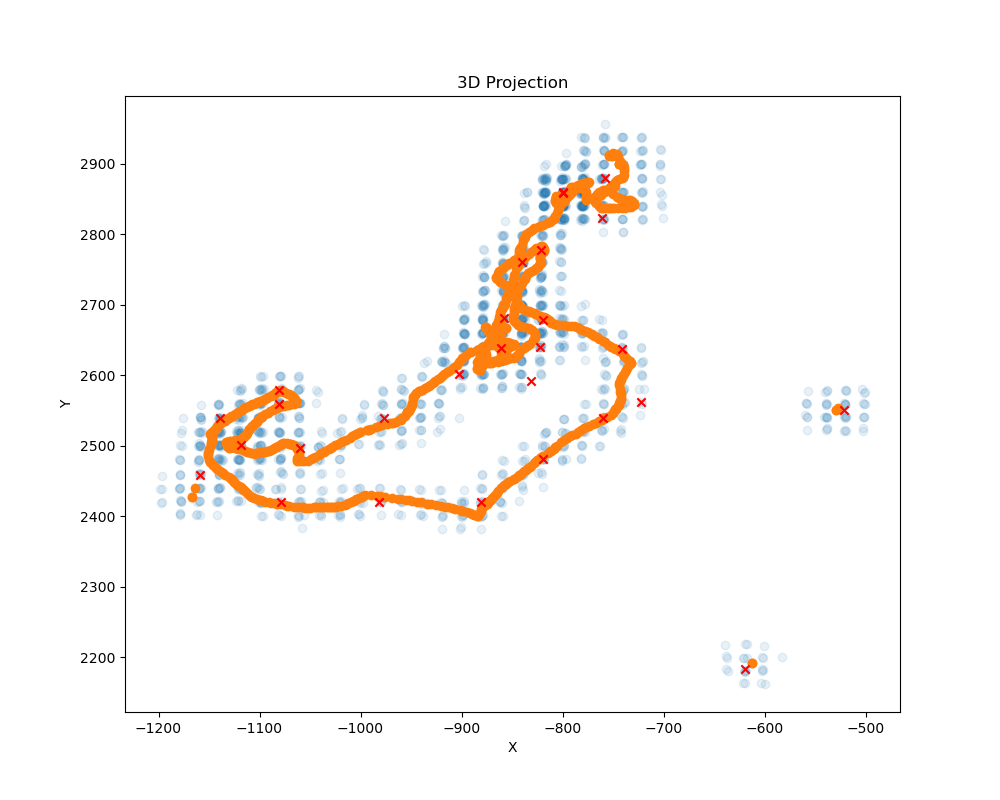

In [7]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o')
plt.scatter(node_centers_df['x'], node_centers_df['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()


In [8]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum']            # Sum energy
    })

# Create final DataFrame
databin = pd.DataFrame(result)
display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,395850.0,-1110.0,2460.0,4725.0,-1158.499023,2458.559570,4680.256836,0.129121
1,395850.0,-1110.0,2565.0,4725.0,-1139.188232,2538.828613,4760.222656,0.052407
2,395850.0,-1110.0,2460.0,5040.0,-1118.141357,2501.027832,5039.714844,0.065569
3,395850.0,-1110.0,2565.0,4830.0,-1080.592773,2578.434082,4880.157227,0.054275
4,395850.0,-1110.0,2460.0,4620.0,-1078.891479,2419.963623,4599.787109,0.037016
5,395850.0,-1110.0,2565.0,4935.0,-1080.282227,2559.360352,4958.080566,0.016505
6,395850.0,-1110.0,2460.0,5145.0,-1060.043823,2496.961426,5160.306152,0.053010
7,395850.0,-1005.0,2460.0,4515.0,-981.596985,2419.722656,4520.965332,0.034848
8,395850.0,-1005.0,2565.0,5250.0,-976.933167,2539.040283,5199.924316,0.098369
9,395850.0,-900.0,2565.0,5145.0,-902.288452,2601.846680,5179.402832,0.123488


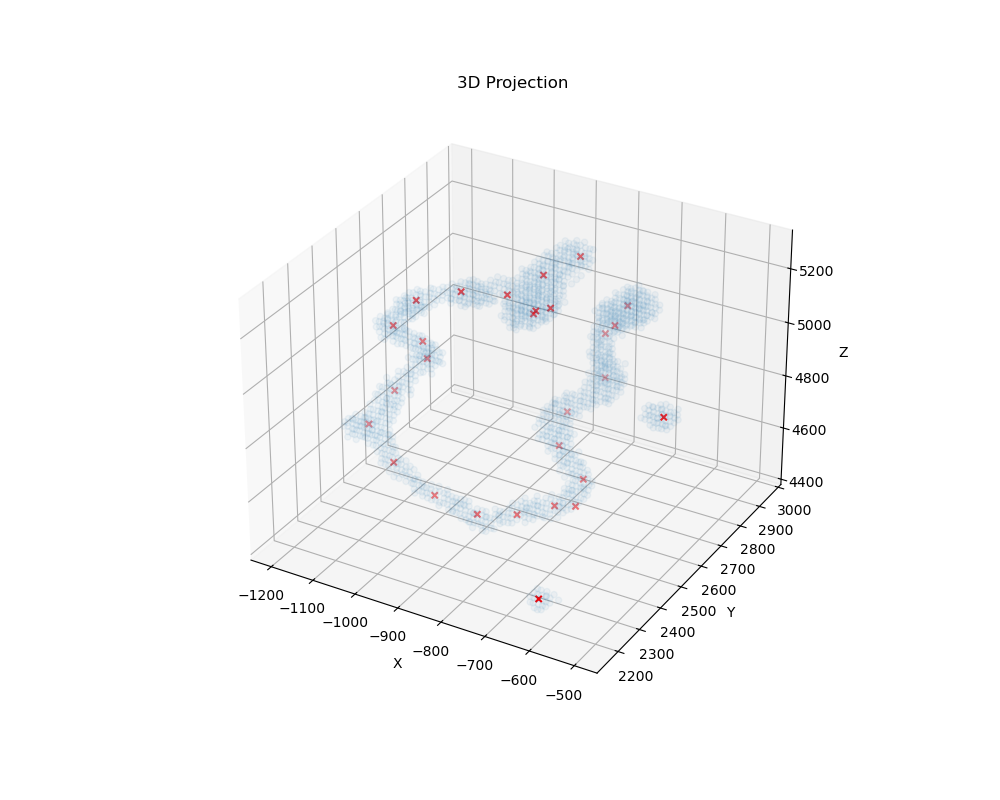

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")

ax.scatter(databin['x'], databin['y'], databin['z'], marker='x',c="r")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

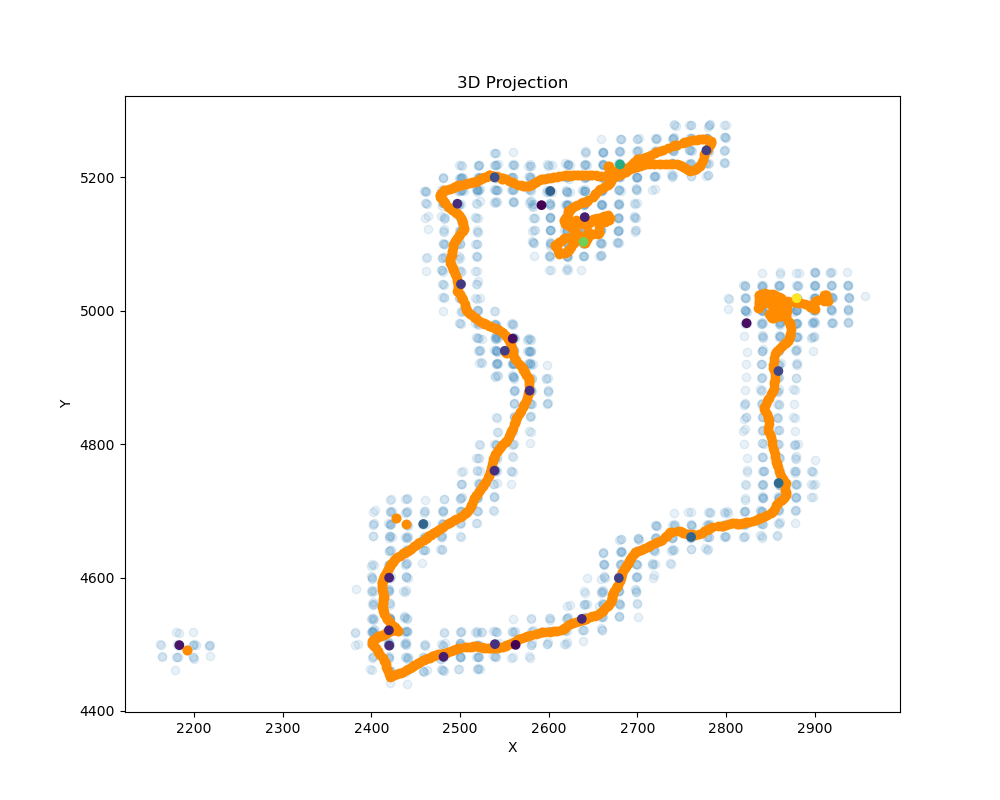

In [10]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['y'], data['z'], marker='o',alpha=0.1)
plt.scatter(data_true['y'], data_true['z'], marker='o',color="DarkOrange")
# plt.scatter(data_true['y'], data_true['z'], marker='o',c=data_true["energy"])
plt.scatter(databin['y'], databin['z'], marker='o',c=databin['energy'])

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()

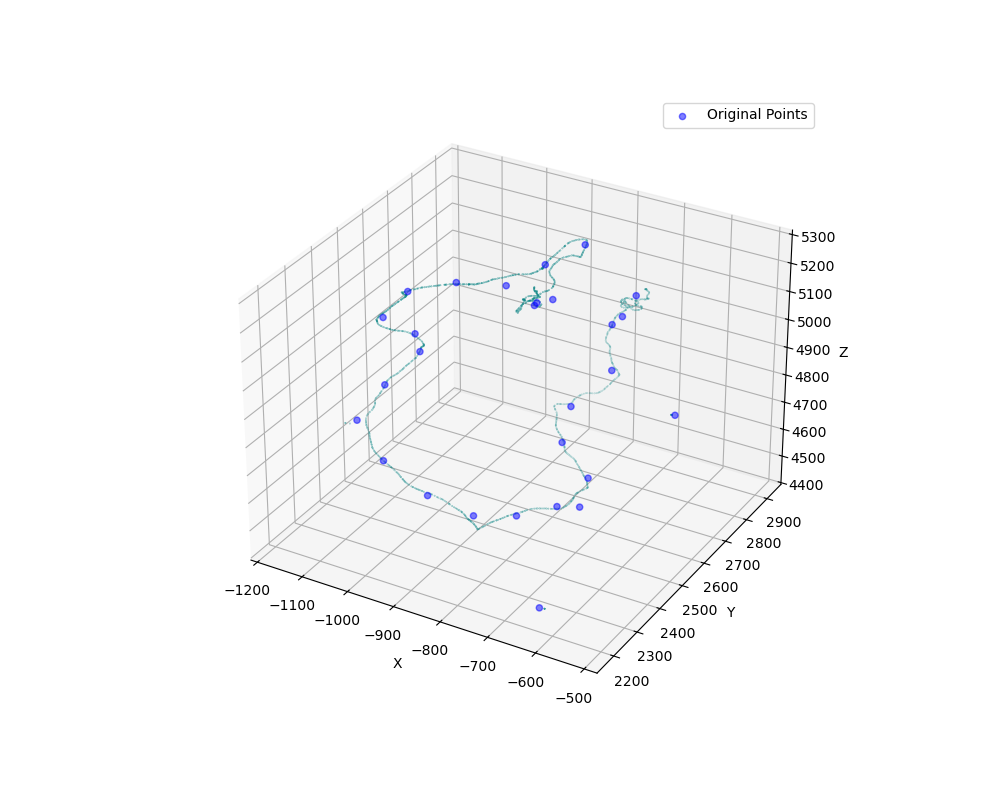

In [11]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,395850.0,-1110.0,2460.0,4725.0,-1158.499023,2458.559570,4680.256836,0.129121
1,395850.0,-1110.0,2565.0,4725.0,-1139.188232,2538.828613,4760.222656,0.052407
2,395850.0,-1110.0,2460.0,5040.0,-1118.141357,2501.027832,5039.714844,0.065569
3,395850.0,-1110.0,2565.0,4830.0,-1080.592773,2578.434082,4880.157227,0.054275
4,395850.0,-1110.0,2460.0,4620.0,-1078.891479,2419.963623,4599.787109,0.037016
5,395850.0,-1110.0,2565.0,4935.0,-1080.282227,2559.360352,4958.080566,0.016505
6,395850.0,-1110.0,2460.0,5145.0,-1060.043823,2496.961426,5160.306152,0.053010
7,395850.0,-1005.0,2460.0,4515.0,-981.596985,2419.722656,4520.965332,0.034848
8,395850.0,-1005.0,2565.0,5250.0,-976.933167,2539.040283,5199.924316,0.098369
9,395850.0,-900.0,2565.0,5145.0,-902.288452,2601.846680,5179.402832,0.123488


Track Building Radius Scale factor is: 3
Median distance to the closest row: 92.39560720510164
Distances to iterate over [  1  20  40  60  79  99 119 139 158 178 198 218 237 257 277]
Dist Thresh 404.92
Pass Flag: True
The primary track is:  0
    event_id            x            y            z    energy  id  primary  \
0   395850.0  -821.178650  2777.965332  5240.268555  0.073671  16        1   
1   395850.0  -858.473877  2680.565918  5219.067383  0.248453  12        1   
2   395850.0  -822.157349  2640.707275  5140.194824  0.035661  15        1   
3   395850.0  -860.669250  2639.257812  5103.076172  0.313661  11        1   
4   395850.0  -831.562073  2591.891602  5158.130859  0.001205  14        1   
5   395850.0  -902.288452  2601.846680  5179.402832  0.123488   9        1   
6   395850.0  -976.933167  2539.040283  5199.924316  0.098369   8        1   
7   395850.0 -1060.043823  2496.961426  5160.306152  0.053010   6        1   
8   395850.0 -1118.141357  2501.027832  5039.714844  0.

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,
16,395850.0,-821.178650,2777.965332,5240.268555,0.073671,16,1,0,0.000000,0.000000,2.008814,1.084587
12,395850.0,-858.473877,2680.565918,5219.067383,0.248453,12,1,0,106.428706,109.757741,1.763355,1.217071
15,395850.0,-822.157349,2640.707275,5140.194824,0.035661,15,1,0,201.971797,65.604318,1.614202,1.045967
11,395850.0,-860.669250,2639.257812,5103.076172,0.313661,11,1,0,255.479384,71.917295,1.640781,1.144425
14,395850.0,-831.562073,2591.891602,5158.130859,0.001205,14,1,0,333.721344,137.687373,1.927808,1.481848
9,395850.0,-902.288452,2601.846680,5179.402832,0.123488,9,1,0,408.245308,103.478386,1.912304,1.701337
8,395850.0,-976.933167,2539.040283,5199.924316,0.098369,8,1,0,507.932860,46.746406,1.731826,1.433273
6,395850.0,-1060.043823,2496.961426,5160.306152,0.053010,6,1,0,609.163342,37.242689,1.642829,1.360761
2,395850.0,-1118.141357,2501.027832,5039.714844,0.065569,2,1,0,743.081686,45.895312,1.775357,1.452632


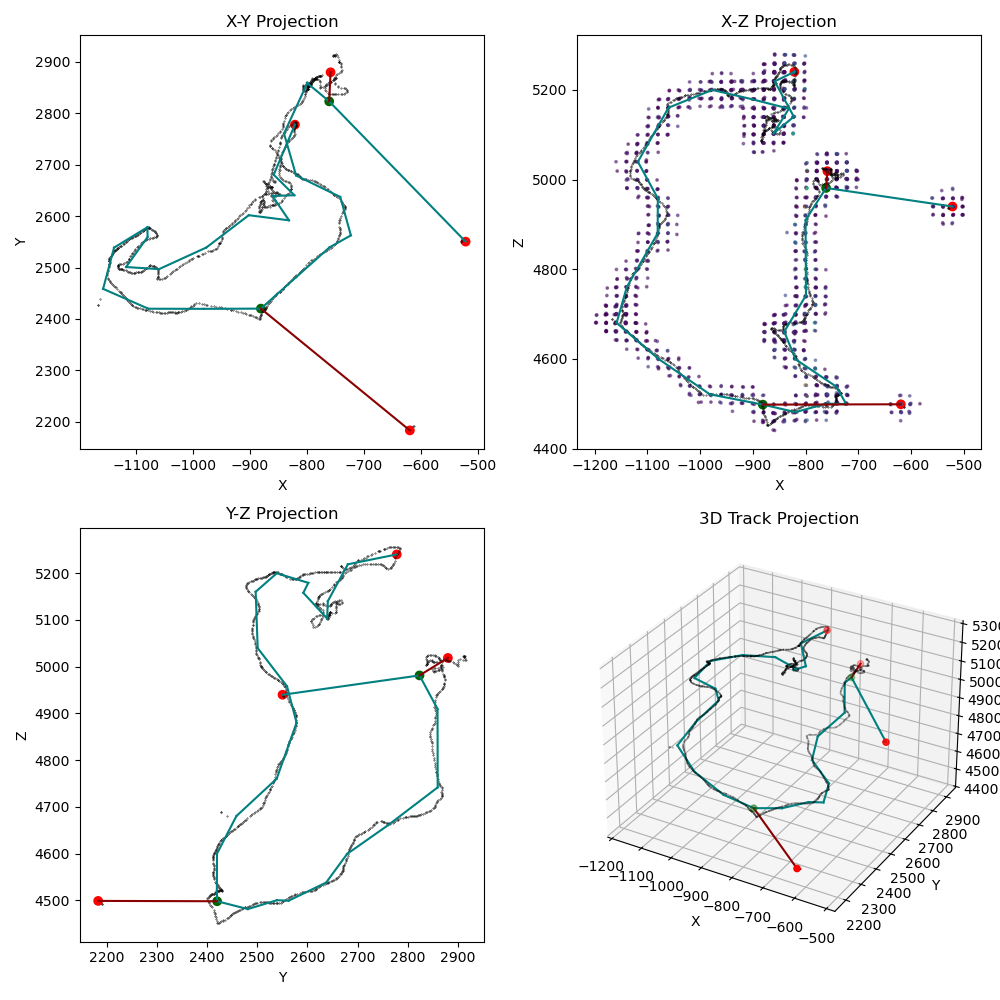

In [12]:
# Apply the tracking reconstruction

display(databin)


# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [13]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

distance_threshold, radius_threshold, T_threshold, pressure:  500.0 180.0 200.0 1
end_tresh: 2605.1332408262824 2805.1332408262824 200.0 1 2
    event_id           x            y            z    energy  id  primary  \
id                                                                          
21  395850.0 -760.935730  2823.303955  4981.291016  0.014668  21        1   
27  395850.0 -520.993408  2550.448242  4939.880859  0.072075  27        1   

    trkID  cumulative_distance      angle  Tortuosity  Squiglicity  
id                                                                  
21      0          2439.432053  36.555971    2.076132     1.825787  
27      0          2805.133241  60.290267    1.830311     1.581677  
end_tresh: 2605.1332408262824 2805.1332408262824 200.0 1 2
    event_id           x            y            z    energy  id  primary  \
id                                                                          
21  395850.0 -760.935730  2823.303955  4981.291016  0.014668 

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,395850.0,0,1,16,27,2805.133,2.039217,0.796139,0.171318,0.357785,0.072075,1.886085,1.953221,200.733542,714.295277,1.150829,1.703732,122.481276,623.056781,Primary
0,395850.0,1,0,10,26,353.202,0.022258,0.022258,0.022258,0.000000,0.022258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Delta0
0,395850.0,2,0,21,23,67.836,0.398115,0.398115,0.398115,0.000000,0.398115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Delta0


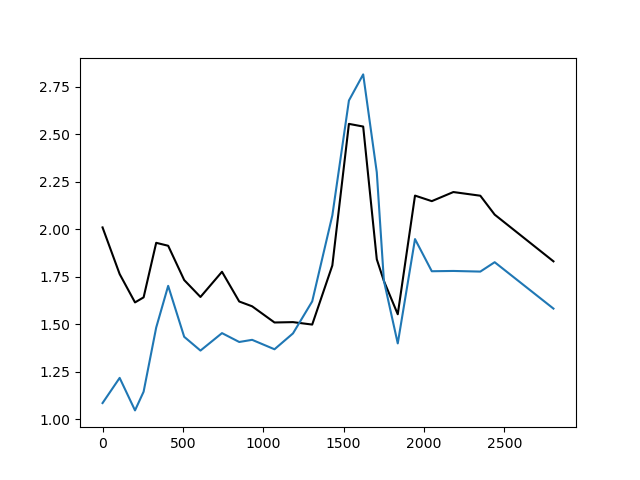

In [14]:
plt.figure()

plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Tortuosity, color="k");
plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Squiglicity);